## Bibliotecas

In [1]:

import pandas as pd
import random
import math
import time
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD
import re
import matplotlib.pyplot as plt
import orloge as ol

# Leitura dos Dados

In [2]:
# Função para ler e processar os dados dos monitores e disciplinas a partir de um arquivo Excel.
# Ela lê o arquivo, limpa os nomes das colunas, remove duplicatas e extrai as colunas relevantes.
# Retorna um dicionário de alunos, uma lista de notas (Na) e uma matriz de disponibilidade (s_ad).
# Parâmetro:
# - path (str): Caminho para o arquivo Excel.
# Retornos:
# - alunos (dict): Dicionário onde a chave é o número USP e contem as seguintes informacoes --
#  -- > [Interesse em ser voluntario(ignorar), pontuacao do aluno (float), criterio de desempate (1, 2 ou 3), lista de materias que ele esta inscrito (Ex: [38, 39, 40]]).
# - Na (list): Lista das notas dos alunos.
# - s_ad (list of lists): Matriz binária de disponibilidade dos alunos para disciplinas.
def ler_dados(path):
    # Padroniza o nome das colunas, para facilitar extracao
    def limpar_nome_coluna(nome):
        return ' '.join(nome.strip().split()).lower()

    # Le e extrai as colunas necessarias
    df = pd.read_excel(path)
    df.columns = [limpar_nome_coluna(col) for col in df.columns]
    df = df.drop_duplicates(subset=['nºusp'], keep='last') # mantem apenas a ultima ocorrencia de um NUSP

    colunas_n = [
        'nºusp',
        'possui pedido de bolsa de estudos em andamento? (a concessão de bolsa de estudos implicará no cancelamento da monitoria a partir do início da vigência da bolsa)',
        'pretende se inscrever no peeg? (o acúmulo das duas monitorias não é permitido. caso o aluno seja selecionado nas duas modalidades precisará optar por uma delas)',
        'departamento de matemática (início da monitoria em 05/08/2024)',
        'departamento de matemática aplicada e estatística (início da monitoria em 05/08/2024)',
        'departamento de ciências de computação (início da monitoria em 05/08/2024)',
        'departamento de sistemas de computação (início da monitoria em 01/09/2024)',
        'tem interesse na monitoria voluntária (sem recebimento de bolsa)?',
        'média ponderada com reprovações'
    ]

    df_colunas = df[colunas_n].copy()

    # Calcula a pontuacao para criterio de desempate dos alunos (3 - mais prioridade, 2 - prioridade media, 1 - prioridade baixa)
    def calcular_pontuacao(row):
        bolsa = row[colunas_n[1]]
        peeg = row[colunas_n[2]]
        if bolsa == 'Sim' and peeg == 'Sim':
            return 1
        elif bolsa == 'Não' and peeg == 'Não':
            return 3
        return 2

    df_colunas['bolsa_peeg_status'] = df_colunas.apply(calcular_pontuacao, axis=1)
    df_colunas = df_colunas.drop([colunas_n[1], colunas_n[2]], axis=1)

    # Faz o mapeamento dos departamentos presentes na planilha
    departamento_mapping = {
        colunas_n[3]: 1,
        colunas_n[4]: 2,
        colunas_n[5]: 3,
        colunas_n[6]: 4
    }

    # Extrai as materias presentes na planilha
    materias_set = set()
    materias_dict = {}
    materia_index = 0

    for dept_col, dept_num in departamento_mapping.items():
        for materias in df_colunas[dept_col].dropna():
            for materia in materias.split(','):
                materia = materia.strip()
                if materia not in materias_set:
                    materias_set.add(materia)
                    materias_dict[materia_index] = (materia, dept_num)
                    materia_index += 1

    # Extrai os alunos, sua nota, sua pontuacao de desempate, se tem interesse em ser voluntario e as materias que ele se inscreveu
    alunos = df_colunas.set_index('nºusp').T.to_dict('list')

    Na = []
    for usp, valores in alunos.items():
        materias_combinadas = []
        valores_limpos = []
        for valor in valores:
            if isinstance(valor, str) and '-' in valor:
                for materia in valor.split(','):
                    materia = materia.strip()
                    for indice, (mat, dept) in materias_dict.items():
                        if materia == mat:
                            materias_combinadas.append(indice)
                            break
            elif isinstance(valor, str) and (valor.upper() == 'POS' or valor.upper() == 'PÓS'): # atribui a nota 1 caso o aluno for da pos, para diminuir sua prioridade
                valores_limpos.append(1)
            elif not pd.isna(valor):
                valores_limpos.append(valor)

        if materias_combinadas:
            valores_limpos.append(sorted(materias_combinadas))

        alunos[usp] = valores_limpos
        nota = valores_limpos[1] if len(valores_limpos) > 1 else None
        Na.append(nota)

    s_ad = [
        [1 if materia in valores_limpos[-1] else 0 for materia in materias_dict.keys()]
        for usp, valores_limpos in alunos.items()
    ]

    return alunos, Na, s_ad

# Modelo

In [ ]:
# Função para criar o modelo de otimização de alocação de monitores com base nos dados fornecidos.
# Parâmetros:
# - alunos (dict): Dicionário de alunos (informações como notas, disponibilidade etc).
# - Na (list): Lista de notas dos alunos.
# - s_ad (list of lists): Matriz de disponibilidade dos alunos para disciplinas.
# - materias (list): Lista de todas as disciplinas.
# Retorno: Deve retornar o modelo de otimização, variáveis e os dados para análise posterior.
def criar_modelo(alunos, Na, s_ad, materias):
    # Voce deve implementar esta parte (foi deixado um exemplo de como pegar os parametros)
    # Esta é apenas uma sugestão de implementacao, voce pode mudar esta funcao se desejar ou ate criar o modelo
    # diretamente no codigo sem usar uma funcao (recomendo fortemente que nao faca isso)

    # Conjunto de monitores (A) e disciplinas (D)
    A = list(range(len(alunos)))
    D = materias

    '''
    Modelo de Otimizacao
    '''
    modelo = LpProblem("Alocacao_de_Monitores", LpMaximize)

    # Variaveis de decisao
    x_ad = LpVariable.dicts("x", [(a, d) for a in A for d in D], cat=LpBinary)
    y_d = LpVariable.dicts("y", D, cat=LpBinary)

    # Funcao objetivo
    modelo += lpSum(Na[a] * x_ad[(a, d)] for a in A for d in D) - lpSum(y_d[d] for d in D)

    '''
    Restrições
    '''

    # Cada disciplina deve ter no maximo um monitor ou nao ter monitor
    for d in D:
        modelo += lpSum(x_ad[(a, d)] for a in A) + y_d[d] == 1, f"Restricao_disciplina_{d}"

    # Cada monitor pode ser alocado a no maximo uma disciplina
    for a in A:
        modelo += lpSum(x_ad[(a, d)] for d in D) <= 1, f"Restricao_monitor_{a}"

    # Um monitor so pode ser alocado a uma disciplina se ele estiver disposto (s_{ad} = 1)
    for a in A:
        for d in D:
            modelo += x_ad[(a, d)] <= s_ad[a][d], f"Restricao_disposicao_{a}_{d}"


    return modelo, x_ad, y_d, D

# Função para resolver o modelo de otimização com base em parâmetros fornecidos.
# Parâmetros:
# - modelo (pulp.LpProblem): O modelo de otimização que será resolvido.
# - presolve (int): Se 1, presolve é ativado; se 0, é desativado.
# - cortes (int): Intensidade da geracao de cortes (0 desativa).
# Retorno: O modelo resolvido.
def resolver_modelo(modelo, presolve, cortes):
    # Configurar as opções do solver
    modelo.preprocess = presolve  # Define preprocess (-1, 0, 1)
    
    modelo.cuts = cortes  # Define geração de cortes (-1, 0, 1, 2, 3)

    # Medir o tempo de execução
    start_time = time.time()

    # Resolver o modelo
    solver = PULP_CBC_CMD(msg=False, logPath='cbc_solver.log', timeLimit=30 * 60) # Time Limit de 30 min
    modelo.solve(solver)

    # Calcular o tempo de execução
    execution_time = time.time() - start_time

    # Exibir as informações do modelo resolvido
    print(f"Solução Encontrada: {modelo.objective.value}")
    # print(f"Gap: {modelo.gap * 100:.2f}%")
    print("Status da solução:", modelo.status, modelo.status)
    print(f"Tempo de execução: {execution_time:.2f} segundos")

    gap = get_gap_from_log('cbc_solver.log')

    print(f'gap = {gap}')

    if(gap == None):
        print('gap None')

    return modelo, modelo.objective.value(), execution_time, gap

# Função para exibir as informações dos monitores alocados e não alocados, além das disciplinas não atendidas.
# Parâmetros:
# - m (pulp.LpProblem): O modelo de otimização resolvido.
# - x_ad (dict): Variáveis de decisão indicando a alocação dos monitores às disciplinas.
# - y_d (dict): Variáveis de decisão indicando disciplinas não atendidas.
# - alunos (dict): Dicionário contendo as informações dos alunos.
# - D (list): Lista de disciplinas disponíveis.
# - s_ad (list of lists): Matriz de disponibilidade dos monitores para as disciplinas.
# Retorno: Nenhum. A função imprime os resultados diretamente.
def informacoes_monitores(m, x_ad, y_d, alunos, D, s_ad):
    monitores_alocados = []
    monitores_nao_alocados = []

    # Exibe os monitores alocados para disciplinas
    for a in range(len(alunos)):
        alocado = False
        for d in D:
            if x_ad[(a,d)].varValue >= 0.99:  # Verifica se a variável é 1
                monitores_alocados.append(f"Monitor {list(alunos.keys())[a]} foi alocado para a disciplina {d}.")
                alocado = True

        # Caso o monitor não tenha sido alocado, armazenar a informação para exibir depois
        if not alocado:
            disciplinas_inscrito = [d for d in D if s_ad[a][d] == 1]
            monitores_nao_alocados.append(f"Monitor {list(alunos.keys())[a]} NÃO foi alocado. Inscrito para as disciplinas: {disciplinas_inscrito}")

    # Exibir os monitores alocados
    print("\nMonitores alocados:")
    for alocacao in monitores_alocados:
        print(alocacao)

    # Exibir os monitores não alocados
    print("\nMonitores não alocados:")
    for nao_alocacao in monitores_nao_alocados:
        print(nao_alocacao)

    # Mostrar disciplinas não atendidas e os monitores que se inscreveram para elas
    print("\nDisciplinas não atendidas e seus inscritos:")
    for d in D:
        if y_d[d].varValue >= 0.99:  # Verifica se a variável é 1
            monitores_inscritos = [list(alunos.keys())[a] for a in range(len(alunos)) if s_ad[a][d] == 1]
            if monitores_inscritos:
                print(f"A disciplina {d} não foi atendida por nenhum monitor. Inscritos: {monitores_inscritos}")
            else:
                print(f"A disciplina {d} não foi atendida por nenhum monitor e não possui inscritos.")

'''
FUNÇÃO PARA PEGAR O GAP
'''
def get_gap_from_log(path):
    try:
        with open(path, 'r') as f:

            logs_dict = ol.get_info_solver(path, 'CBC') # Orloge returns a dict with all logs info

            best_bound, best_solution = logs_dict["best_bound"], logs_dict["best_solution"]

            # print(f'best_bound = {best_bound}')
            # print(f'best_solution = {best_solution}')
            # print(f'logs_dict = {logs_dict}')

            if best_bound is not None and best_solution is not None :
                gap = abs(best_solution - best_bound) / (1e-10 + abs(best_bound)) * 100 # Gap in %. We add 1e-10 to avoid division by zero.
                return gap
            else :
                print("Unable to retrieve gap.")
                return None

    except FileNotFoundError:
        print("Arquivo de log não encontrado.")
        return None


# Gerar Instâncias Maiores

In [4]:
# Função para aumentar os dados de alunos e matérias com base na escala fornecida.
# Parâmetros:
# - file_path (str): Caminho para o arquivo Excel com os dados originais.
# - escala (float): Fator de aumento dos dados (e.g., 1.5 para aumentar em 50%).
# Retorno: Retorna os dados aumentados (alunos, notas, disponibilidade dos alunos para disciplinas e a lista de matérias).
def aumentar_dados(path, escala):
    # Lê os dados originais usando a função existente
    alunos_originais, Na_originais, s_ad_originais = ler_dados(path)
    seed = 0

    # Se seed for 0 e escala for 1, retornar os dados originais
    if seed == 0 and escala == 1:
        todas_materias = list(range(len(s_ad_originais[0])))
        return alunos_originais, Na_originais, s_ad_originais, todas_materias

    # Define a seed para a geração de dados aleatórios
    if seed is not None:
        random.seed(seed)

    novos_alunos = {}
    novas_notas = []
    nova_s_ad = []
    usp_existentes = set(alunos_originais.keys())
    max_usp = max(usp_existentes)

    # Aumenta o número de materias em 1.12x com base na escala
    num_materias_originais = len(s_ad_originais[0])
    num_novas_materias = math.ceil(num_materias_originais * 1.12 * escala)

    # Novos índices para as matérias que serão adicionadas
    novas_materias = list(range(num_materias_originais, num_materias_originais + num_novas_materias))

    # Aumenta o numero de alunos conforme a escala
    total_alunos = len(alunos_originais)
    num_novos_alunos = math.ceil(total_alunos * (escala - 1))  # Cria novos alunos além dos originais

    # Cria os novos alunos
    for i in range(num_novos_alunos):
        # Novo Nusp
        max_usp += 1
        novo_usp = max_usp
        usp_existentes.add(novo_usp)

        # Gerar uma nova nota aleatória para o novo aluno
        nova_nota = random.uniform(0, 10)
        novas_notas.append(nova_nota)

        # Gerar matérias aleatórias (entre 2 e 4) para cada novo aluno
        num_materias_aluno = random.randint(2, 4)
        todas_materias = list(range(num_materias_originais)) + novas_materias  # Considera matérias antigas e novas
        materias_aluno = random.sample(todas_materias, num_materias_aluno)

        # Criar a matriz de disponibilidade (s_ad) para o novo aluno com as matérias selecionadas
        disponibilidade_aluno = [1 if materia in materias_aluno else 0 for materia in todas_materias]
        nova_s_ad.append(disponibilidade_aluno)

        novos_alunos[novo_usp] = []

    # Expande a matriz s_ad original para acomodar as novas matérias
    s_ad_expandidos = [row + [0] * len(novas_materias) for row in s_ad_originais]
    s_ad_expandidos += nova_s_ad

    # Combinar os dados originais e os novos
    alunos_expandidos = {**alunos_originais, **novos_alunos}
    Na_expandidos = Na_originais + novas_notas

    return alunos_expandidos, Na_expandidos, s_ad_expandidos, todas_materias

### Testes Computacionais

1. Execute o modelo utilizando a instância ”Dados_monitores.xlsx” (disponibilizada na página da disciplina) e apresente o resultado por meio da função informacoes_monitores (fornecida no código disponível na página da disciplina). Analise a solução considerando o número de monitores alocados e as disciplinas sem alocação de monitores.

In [6]:
# Caminho do arquivo Excel com os dados originais
path = '/home/greff/Desktop/scheduler-class-assistant/dataset/Dados_monitores.xlsx'

# Aumenta os dados de alunos e matérias
alunos, Na, s_ad, materias = aumentar_dados(path, escala=1)

# Cria o modelo de otimização com os dados aumentados
mod, x_ad, y_d, D = criar_modelo(alunos, Na, s_ad, materias)

# Resolve o modelo
m, obj, _, _ = resolver_modelo(mod, 1, 1)

informacoes_monitores(m, x_ad, y_d, alunos, D, s_ad)


Solução Encontrada: <bound method LpAffineExpression.value of 6.8*x_(0,_0) + 6.8*x_(0,_1) + 6.8*x_(0,_10) + 6.8*x_(0,_11) + 6.8*x_(0,_12) + 6.8*x_(0,_13) + 6.8*x_(0,_14) + 6.8*x_(0,_15) + 6.8*x_(0,_16) + 6.8*x_(0,_17) + 6.8*x_(0,_18) + 6.8*x_(0,_19) + 6.8*x_(0,_2) + 6.8*x_(0,_20) + 6.8*x_(0,_21) + 6.8*x_(0,_22) + 6.8*x_(0,_23) + 6.8*x_(0,_24) + 6.8*x_(0,_25) + 6.8*x_(0,_26) + 6.8*x_(0,_27) + 6.8*x_(0,_28) + 6.8*x_(0,_29) + 6.8*x_(0,_3) + 6.8*x_(0,_30) + 6.8*x_(0,_31) + 6.8*x_(0,_32) + 6.8*x_(0,_33) + 6.8*x_(0,_34) + 6.8*x_(0,_35) + 6.8*x_(0,_36) + 6.8*x_(0,_37) + 6.8*x_(0,_38) + 6.8*x_(0,_39) + 6.8*x_(0,_4) + 6.8*x_(0,_40) + 6.8*x_(0,_41) + 6.8*x_(0,_42) + 6.8*x_(0,_43) + 6.8*x_(0,_44) + 6.8*x_(0,_45) + 6.8*x_(0,_46) + 6.8*x_(0,_47) + 6.8*x_(0,_48) + 6.8*x_(0,_49) + 6.8*x_(0,_5) + 6.8*x_(0,_50) + 6.8*x_(0,_51) + 6.8*x_(0,_52) + 6.8*x_(0,_53) + 6.8*x_(0,_54) + 6.8*x_(0,_55) + 6.8*x_(0,_56) + 6.8*x_(0,_57) + 6.8*x_(0,_58) + 6.8*x_(0,_59) + 6.8*x_(0,_6) + 6.8*x_(0,_60) + 6.8*x_(0,_61) + 6

2. Analise, do ponto de vista do gestor, o que fazer no caso de haver disciplinas sem monitores, mas existirem monitores que já cursaram essas disciplinas, porém não se inscreveram nelas. Não é necessário implementar nenhum código.

**R:** O ideal a se fazer seria sugerir a esses monitores a opção de monitorar as disciplinas sem monitores.

3. Selecione arbitrariamente 5 alunos monitores e atribua-os a disciplinas compatíveis (dica: fixe as variáveis escolhidas em valores determinados). Exiba novamente o resultado gerado pelo modelo e comente brevemente as diferenças entre a nova solução e a anterior. A função objetivo foi significativamente alterada? O número de disciplinas não atendidas aumentou?

In [7]:
# Caminho do arquivo Excel com os dados originais
path = '/home/greff/Desktop/scheduler-class-assistant/dataset/Dados_monitores.xlsx'

# Aumenta os dados de alunos e matérias
alunos, Na, s_ad, materias = aumentar_dados(path, escala=1)

alunos_selecionados = [11780000, 13870027, 12550032, 12550033, 13690044]
disciplinas_novas = [20, 44, 45, 46, 18]

mapa_alunos = {nUSP: idx for idx, nUSP in enumerate(alunos)}
mapa_disciplinas = {d: idx for idx, d in enumerate(materias)}

for nUSP, d in zip(alunos_selecionados, disciplinas_novas):
    data = alunos[nUSP]

    if d not in data[3]:
        data[3].append(d)

    # Atualizar s_ad usando os mapeamentos
    if nUSP in mapa_alunos and d in mapa_disciplinas:
        aluno_idx = mapa_alunos[nUSP]
        disciplina_idx = mapa_disciplinas[d]
        s_ad[aluno_idx][disciplina_idx] = 1
    else:
        print(f"Erro: Aluno {nUSP} ou disciplina {d} não encontrados nos mapeamentos.")


print(alunos)


{11780000: ['Sim', 6.8, 3, [38, 39, 40, 20]], 14590001: ['Não', 8.8, 3, [0, 1, 2, 3, 4, 19, 20, 38, 39, 40, 55, 56]], 12730002: ['Sim', 6.9, 2, [41, 56, 57]], 14740004: ['Não', 8.6, 3, [5, 39]], 12680005: ['Não', 1.9, 3, [38, 39, 40, 56]], 14580006: ['Não', 8.7, 3, [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 38, 39, 40, 55, 56]], 10740003: ['Não', 6.5, 2, [38, 39, 40, 41, 42, 55, 56, 57]], 14570008: ['Não', 8.3, 2, [0, 7, 12, 23, 24]], 10270009: ['Não', 1, 3, [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20, 24, 25, 26, 27, 38, 39, 40, 41, 42, 43, 44, 45, 55, 56, 57, 58, 59, 60, 61]], 77770010: ['Não', 7.4, 3, [38, 39, 40, 41, 55, 56]], 14550011: ['Não', 7.6, 3, [56]], 12540012: ['Não', 8.8, 3, [19, 20, 38, 39, 40, 46, 47, 55, 56]], 13740007: ['Não', 8, 3, [27]], 14560014: ['Não', 9.1, 3, [28]], 13690016: ['Não', 7.3, 2, [48, 59]], 11910017: ['Não', 6.3, 3, [27]], 11210018: ['Não', 7.3, 2, [0, 5, 29, 38]], 13860019: ['Não', 5.6, 2, [6, 8, 9, 12, 62]], 10690020: ['Não', 8.6, 

In [8]:
mod, x_ad, y_d, D = criar_modelo(alunos, Na, s_ad, materias)

m, _, _, _ = resolver_modelo(mod, 1, 1)

informacoes_monitores(m, x_ad, y_d, alunos, D, s_ad)

Solução Encontrada: <bound method LpAffineExpression.value of 6.8*x_(0,_0) + 6.8*x_(0,_1) + 6.8*x_(0,_10) + 6.8*x_(0,_11) + 6.8*x_(0,_12) + 6.8*x_(0,_13) + 6.8*x_(0,_14) + 6.8*x_(0,_15) + 6.8*x_(0,_16) + 6.8*x_(0,_17) + 6.8*x_(0,_18) + 6.8*x_(0,_19) + 6.8*x_(0,_2) + 6.8*x_(0,_20) + 6.8*x_(0,_21) + 6.8*x_(0,_22) + 6.8*x_(0,_23) + 6.8*x_(0,_24) + 6.8*x_(0,_25) + 6.8*x_(0,_26) + 6.8*x_(0,_27) + 6.8*x_(0,_28) + 6.8*x_(0,_29) + 6.8*x_(0,_3) + 6.8*x_(0,_30) + 6.8*x_(0,_31) + 6.8*x_(0,_32) + 6.8*x_(0,_33) + 6.8*x_(0,_34) + 6.8*x_(0,_35) + 6.8*x_(0,_36) + 6.8*x_(0,_37) + 6.8*x_(0,_38) + 6.8*x_(0,_39) + 6.8*x_(0,_4) + 6.8*x_(0,_40) + 6.8*x_(0,_41) + 6.8*x_(0,_42) + 6.8*x_(0,_43) + 6.8*x_(0,_44) + 6.8*x_(0,_45) + 6.8*x_(0,_46) + 6.8*x_(0,_47) + 6.8*x_(0,_48) + 6.8*x_(0,_49) + 6.8*x_(0,_5) + 6.8*x_(0,_50) + 6.8*x_(0,_51) + 6.8*x_(0,_52) + 6.8*x_(0,_53) + 6.8*x_(0,_54) + 6.8*x_(0,_55) + 6.8*x_(0,_56) + 6.8*x_(0,_57) + 6.8*x_(0,_58) + 6.8*x_(0,_59) + 6.8*x_(0,_6) + 6.8*x_(0,_60) + 6.8*x_(0,_61) + 6

**R:** O valor da função objetivo aumentou de 478 para 511. Como as disciplinas adicionadas foram aquelas que ficaram sem monitores, todas disciplinas receberam monitores.

4. Utilize a função aumentar_dados (fornecida no código disponível na página da disciplina) para gerar instâncias de maior complexidade. Crie 5 instâncias com fatores de escala 2,3,5,10,15. Apresente uma tabela com os resultados obtidos, incluindo o gap e o tempo de execução de cada instância. Comente sobre os resultados, estabelecendo um limite de 30 minutos para a resolução de cada instância.

In [ ]:
%%capture

escalas = [2, 3, 5, 10, 15]
times = []
objs_values = []
gaps = []

for e in escalas:
    # Aumenta os dados de alunos e matérias
    alunos, Na, s_ad, materias = aumentar_dados(path, escala=e)

    # Cria o modelo de otimização com os dados aumentados
    mod, x_ad, y_d, D = criar_modelo(alunos, Na, s_ad, materias)

    # Resolve o modelo
    m, obj, t, gap = resolver_modelo(mod, 1, 1)

    times.append(t)
    objs_values.append(obj)
    if(gap != None):
        gaps.append(gap)

    

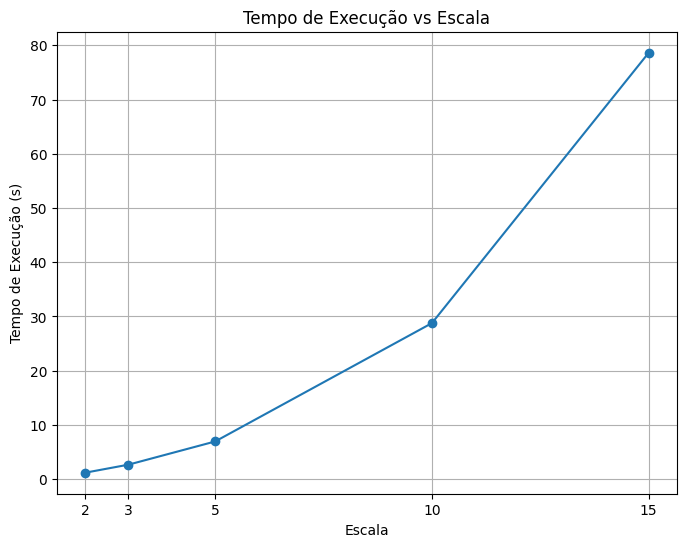

In [ ]:
# Gráfico 1: Escala vs Tempo de Execução
plt.figure(figsize=(8, 6))
plt.plot(escalas, times, marker='o', linestyle='-')
plt.title('Tempo de Execução vs Escala')
plt.xlabel('Escala')
plt.ylabel('Tempo de Execução (s)')
plt.xticks(escalas)
plt.grid(True)
plt.show()

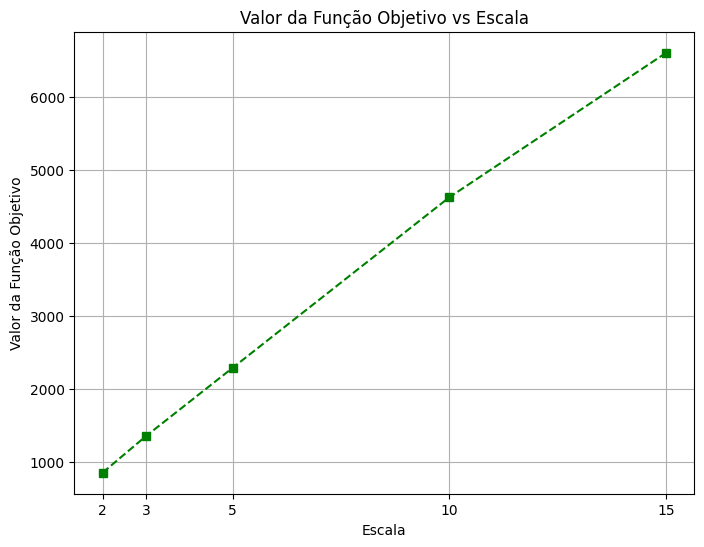

In [14]:
# Gráfico 2: Escala vs Valor da Função Objetivo
plt.figure(figsize=(8, 6))
plt.plot(escalas, objs_values, marker='s', linestyle='--', color='green')
plt.title('Valor da Função Objetivo vs Escala')
plt.xlabel('Escala')
plt.ylabel('Valor da Função Objetivo')
plt.xticks(escalas)
plt.grid(True)
plt.show()

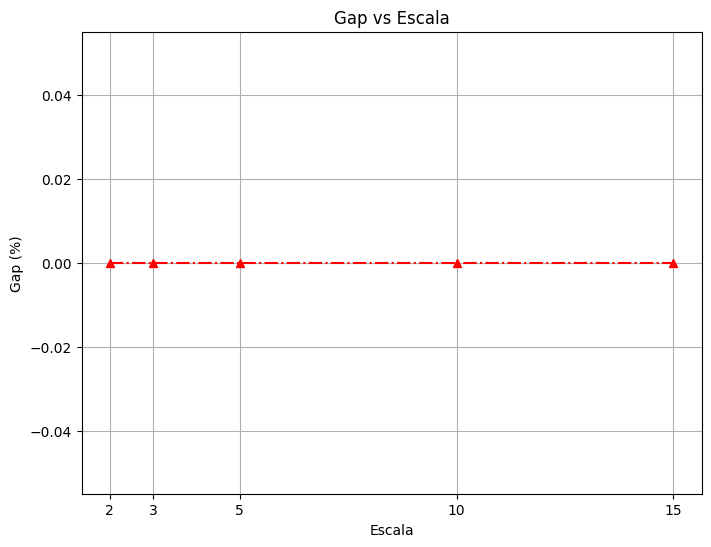

In [15]:
# Gráfico 3: Escala vs Gap
plt.figure(figsize=(8, 6))
plt.plot(escalas, gaps, marker='^', linestyle='-.', color='red')
plt.title('Gap vs Escala')
plt.xlabel('Escala')
plt.ylabel('Gap (%)')
plt.xticks(escalas)
plt.grid(True)
plt.show()

5. Desative a opção cuts ao resolver as mesmas instâncias do item anterior e apresente os novos resultados, comentando sobre eles.

In [ ]:
%%capture

escalas = [2, 3, 5, 10, 15]
times = []
objs_values = []
gaps = []

for e in escalas:
    # Aumenta os dados de alunos e matérias
    alunos, Na, s_ad, materias = aumentar_dados(path, escala=e)

    # Cria o modelo de otimização com os dados aumentados
    mod, x_ad, y_d, D = criar_modelo(alunos, Na, s_ad, materias)

    # Resolve o modelo
    m, obj, t, gap = resolver_modelo(mod, 1, -1) # Cuts desativado

    times.append(t)
    objs_values.append(obj)
    if(gap != None):
        gaps.append(gap)

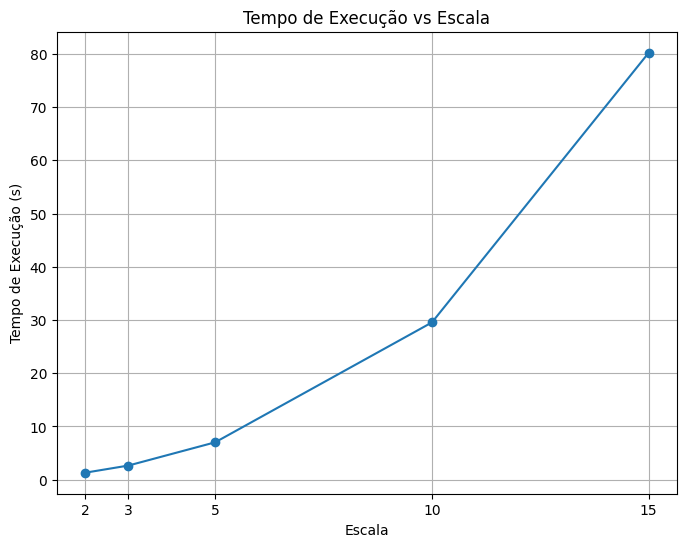

In [17]:
# Gráfico 1: Escala vs Tempo de Execução
plt.figure(figsize=(8, 6))
plt.plot(escalas, times, marker='o', linestyle='-')
plt.title('Tempo de Execução vs Escala')
plt.xlabel('Escala')
plt.ylabel('Tempo de Execução (s)')
plt.xticks(escalas)
plt.grid(True)
plt.show()

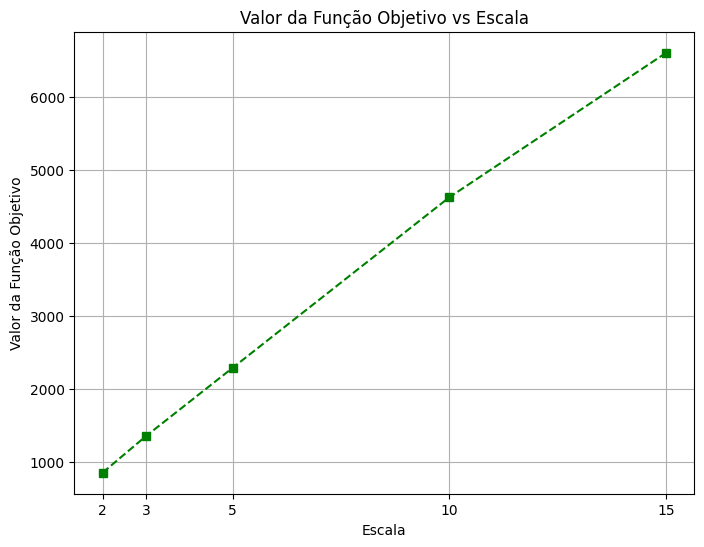

In [18]:
# Gráfico 2: Escala vs Valor da Função Objetivo
plt.figure(figsize=(8, 6))
plt.plot(escalas, objs_values, marker='s', linestyle='--', color='green')
plt.title('Valor da Função Objetivo vs Escala')
plt.xlabel('Escala')
plt.ylabel('Valor da Função Objetivo')
plt.xticks(escalas)
plt.grid(True)
plt.show()

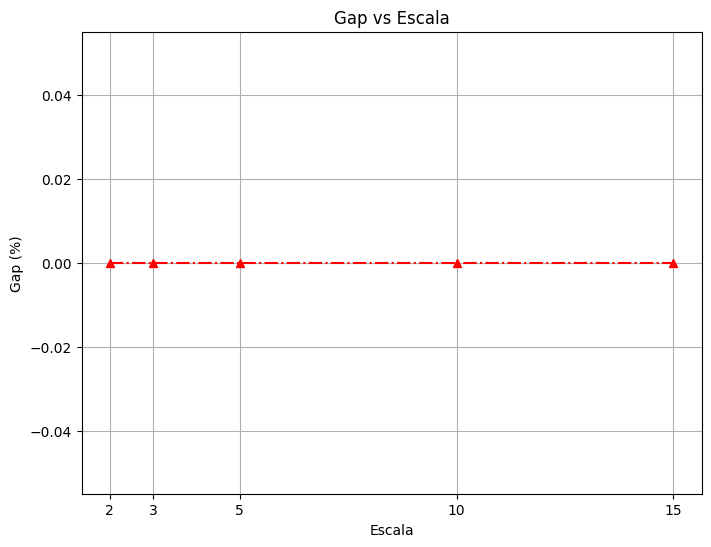

In [19]:
# Gráfico 3: Escala vs Gap
plt.figure(figsize=(8, 6))
plt.plot(escalas, gaps, marker='^', linestyle='-.', color='red')
plt.title('Gap vs Escala')
plt.xlabel('Escala')
plt.ylabel('Gap (%)')
plt.xticks(escalas)
plt.grid(True)
plt.show()

6. Desative a opção presolve ao resolver as mesmas instâncias do item anterior e apresente os novos resultados, comentando sobre eles.

In [20]:
%%capture

escalas = [2, 3, 5, 10, 15]
times = []
objs_values = []
gaps = []

for e in escalas:
    # Aumenta os dados de alunos e matérias
    alunos, Na, s_ad, materias = aumentar_dados(path, escala=e)

    # Cria o modelo de otimização com os dados aumentados
    mod, x_ad, y_d, D = criar_modelo(alunos, Na, s_ad, materias)

    # Resolve o modelo
    m, obj, t, gap = resolver_modelo(mod, 0, 1) # Presolve desativado

    times.append(t)
    objs_values.append(obj)
    if(gap != None):
        gaps.append(gap)

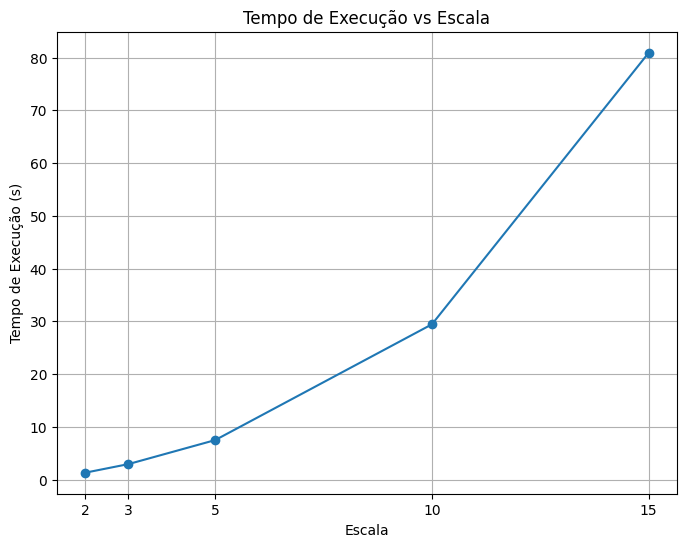

In [21]:
# Gráfico 1: Escala vs Tempo de Execução
plt.figure(figsize=(8, 6))
plt.plot(escalas, times, marker='o', linestyle='-')
plt.title('Tempo de Execução vs Escala')
plt.xlabel('Escala')
plt.ylabel('Tempo de Execução (s)')
plt.xticks(escalas)
plt.grid(True)
plt.show()

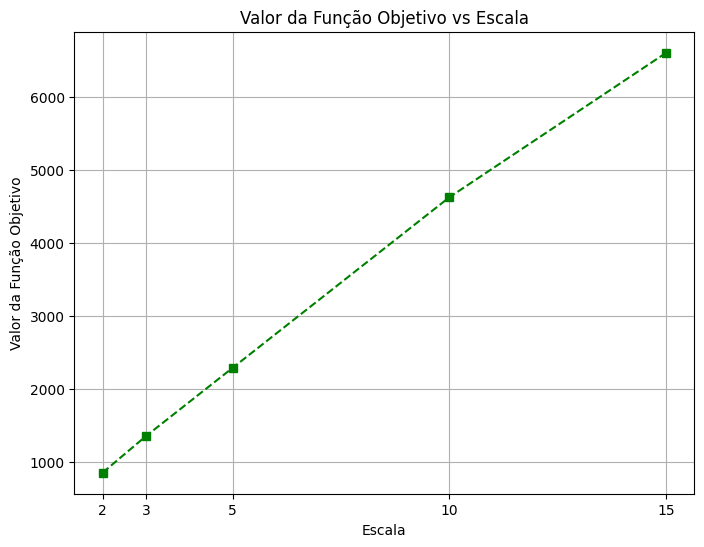

In [22]:
# Gráfico 2: Escala vs Valor da Função Objetivo
plt.figure(figsize=(8, 6))
plt.plot(escalas, objs_values, marker='s', linestyle='--', color='green')
plt.title('Valor da Função Objetivo vs Escala')
plt.xlabel('Escala')
plt.ylabel('Valor da Função Objetivo')
plt.xticks(escalas)
plt.grid(True)
plt.show()

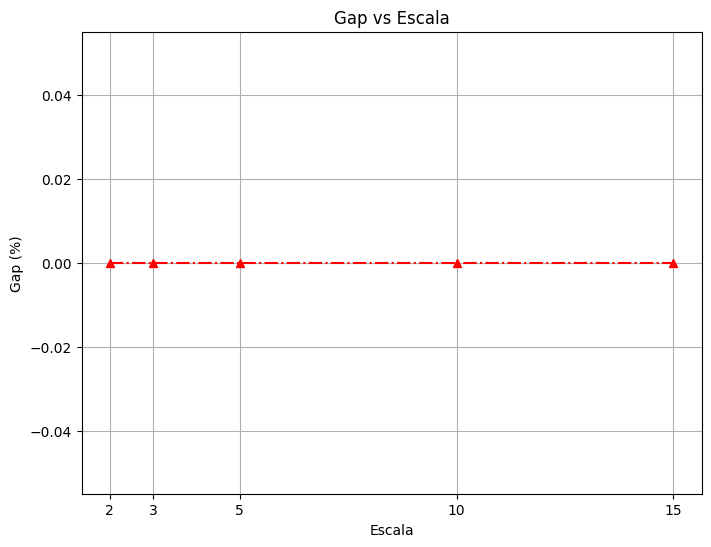

In [23]:
# Gráfico 3: Escala vs Gap
plt.figure(figsize=(8, 6))
plt.plot(escalas, gaps, marker='^', linestyle='-.', color='red')
plt.title('Gap vs Escala')
plt.xlabel('Escala')
plt.ylabel('Gap (%)')
plt.xticks(escalas)
plt.grid(True)
plt.show()

7. Inclua, no modelo, as prioridades dos alunos pelas disciplinas inscritas, que são usadas em caso de empate (caso dois alunos tenham a mesma nota), alterando a função objetivo para considerar esses valores. (Dica: lembre-se de que isso será usado apenas como critério de desempate; as notas ainda devem ser o principal critério de seleção). Analise todas as instâncias para esse novo cenário comparando com o anterior.

In [34]:
def criar_novo_modelo(alunos, Na, s_ad, prioridade_ad, materias):
    # Conjunto de monitores (A) e disciplinas (D)
    A = list(range(len(alunos)))
    D = materias


    # Valor máximo de prioridade
    max_prioridade = max(max(prioridades) for prioridades in prioridade_ad)

    default_priority = max_prioridade + 1
    
    # Ajuste das prioridades
    prioridade_adj = {}
    for a in A:
        for d in D:
            prioridade_adj[(a, d)] = (max_prioridade + 1) - prioridade_ad.get((a, d), default_priority)

    # Multiplicador grande para as notas
    M = 1000

    '''
    Modelo de Otimizacao
    '''
    modelo = LpProblem("Alocacao_de_Monitores", LpMaximize)

    # Variaveis de decisao
    x_ad = LpVariable.dicts("x", [(a, d) for a in A for d in D], cat=LpBinary)
    y_d = LpVariable.dicts("y", D, cat=LpBinary)

    # Funcao objetivo
    modelo += lpSum((M * Na[a] + prioridade_adj[(a, d)]) * x_ad[(a, d)] for a in A for d in D) - lpSum(y_d[d] for d in D)

    '''
    Restrições
    '''

    # Cada disciplina deve ter no maximo um monitor ou nao ter monitor
    for d in D:
        modelo += lpSum(x_ad[(a, d)] for a in A) + y_d[d] == 1, f"Restricao_disciplina_{d}"

    # Cada monitor pode ser alocado a no maximo uma disciplina
    for a in A:
        modelo += lpSum(x_ad[(a, d)] for d in D) <= 1, f"Restricao_monitor_{a}"

    # Um monitor so pode ser alocado a uma disciplina se ele estiver disposto (s_{ad} = 1)
    for a in A:
        for d in D:
            modelo += x_ad[(a, d)] <= s_ad[a][d], f"Restricao_disposicao_{a}_{d}"

    return modelo, x_ad, y_d, D

In [31]:
alunos, Na, s_ad, materias = aumentar_dados(path, escala=1)

print(f'alunos = {alunos}')
print(f'Na = {Na}')
print(f's_ad = {s_ad}')
print(f'materias = {materias}')


alunos = {11780000: ['Sim', 6.8, 3, [38, 39, 40]], 14590001: ['Não', 8.8, 3, [0, 1, 2, 3, 4, 19, 20, 38, 39, 40, 55, 56]], 12730002: ['Sim', 6.9, 2, [41, 56, 57]], 14740004: ['Não', 8.6, 3, [5, 39]], 12680005: ['Não', 1.9, 3, [38, 39, 40, 56]], 14580006: ['Não', 8.7, 3, [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 38, 39, 40, 55, 56]], 10740003: ['Não', 6.5, 2, [38, 39, 40, 41, 42, 55, 56, 57]], 14570008: ['Não', 8.3, 2, [0, 7, 12, 23, 24]], 10270009: ['Não', 1, 3, [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20, 24, 25, 26, 27, 38, 39, 40, 41, 42, 43, 44, 45, 55, 56, 57, 58, 59, 60, 61]], 77770010: ['Não', 7.4, 3, [38, 39, 40, 41, 55, 56]], 14550011: ['Não', 7.6, 3, [56]], 12540012: ['Não', 8.8, 3, [19, 20, 38, 39, 40, 46, 47, 55, 56]], 13740007: ['Não', 8, 3, [27]], 14560014: ['Não', 9.1, 3, [28]], 13690016: ['Não', 7.3, 2, [48, 59]], 11910017: ['Não', 6.3, 3, [27]], 11210018: ['Não', 7.3, 2, [0, 5, 29, 38]], 13860019: ['Não', 5.6, 2, [6, 8, 9, 12, 62]], 10690020: ['Não', 

In [ ]:
# Lista de IDs dos alunos em ordem
A = list(alunos.keys())

# Inicializar o dicionário de prioridades
prioridade_ad = {}
max_priority = 0  # Para encontrar a maior prioridade atribuída

for a_index, aluno_id in enumerate(A):
    disciplinas_inscritas = alunos[aluno_id][3]  # Lista de disciplinas inscritas pelo aluno
    for prioridade, disciplina in enumerate(disciplinas_inscritas, start=1):
        # Mapeia (aluno, disciplina) para a prioridade
        prioridade_ad[(a_index, disciplina)] = prioridade
        if prioridade > max_priority:
            max_priority = prioridade

In [39]:
%%capture

escalas = [2, 3, 5, 10, 15]
times = []
objs_values = []
gaps = []

for e in escalas:
    # Aumenta os dados de alunos e matérias
    alunos, Na, s_ad, materias = aumentar_dados(path, escala=e)

    # Cria o modelo de otimização com os dados aumentados
    mod, x_ad, y_d, D = criar_novo_modelo(alunos, Na, s_ad, prioridade_ad, materias)

    # Resolve o modelo
    m, obj, t, gap = resolver_modelo(mod, 0, 1) # Presolve desativado

    times.append(t)
    objs_values.append(obj)
    if(gap != None):
        gaps.append(gap)

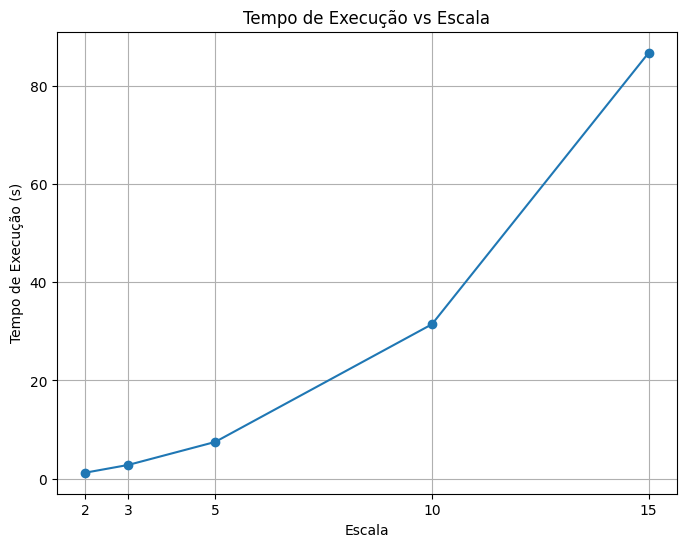

In [40]:
# Gráfico 1: Escala vs Tempo de Execução
plt.figure(figsize=(8, 6))
plt.plot(escalas, times, marker='o', linestyle='-')
plt.title('Tempo de Execução vs Escala')
plt.xlabel('Escala')
plt.ylabel('Tempo de Execução (s)')
plt.xticks(escalas)
plt.grid(True)
plt.show()

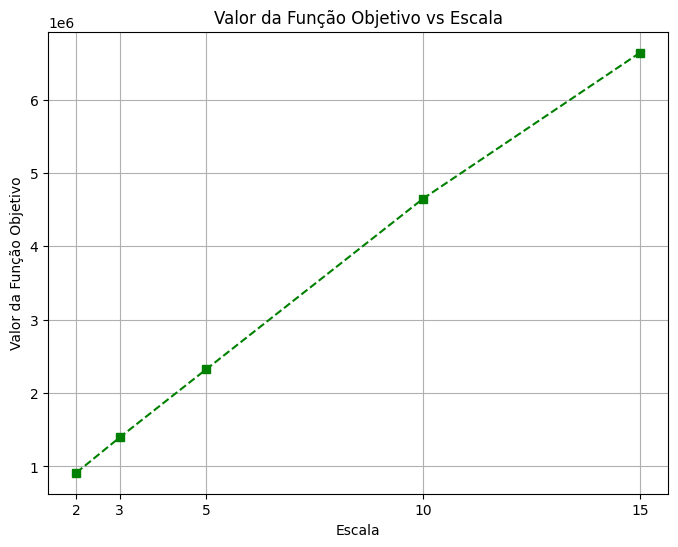

In [41]:
# Gráfico 2: Escala vs Valor da Função Objetivo
plt.figure(figsize=(8, 6))
plt.plot(escalas, objs_values, marker='s', linestyle='--', color='green')
plt.title('Valor da Função Objetivo vs Escala')
plt.xlabel('Escala')
plt.ylabel('Valor da Função Objetivo')
plt.xticks(escalas)
plt.grid(True)
plt.show()

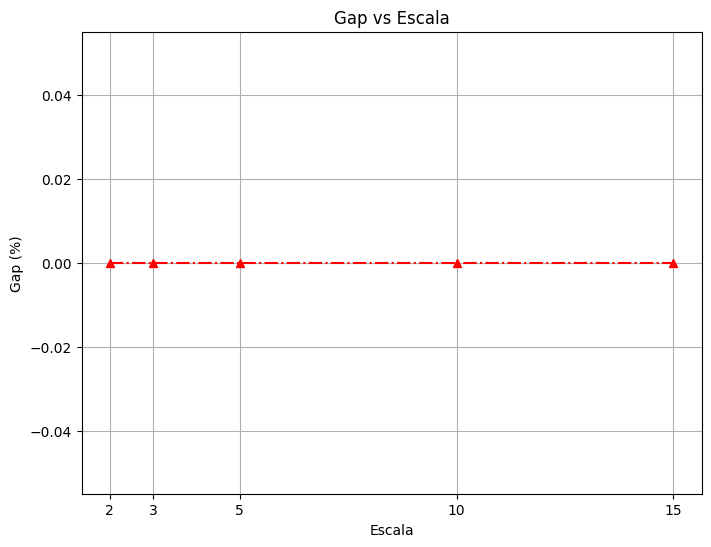

In [42]:
# Gráfico 3: Escala vs Gap
plt.figure(figsize=(8, 6))
plt.plot(escalas, gaps, marker='^', linestyle='-.', color='red')
plt.title('Gap vs Escala')
plt.xlabel('Escala')
plt.ylabel('Gap (%)')
plt.xticks(escalas)
plt.grid(True)
plt.show()